In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus
import time
import pandas as pd
import datetime

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')


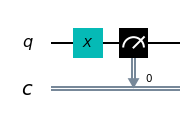

In [3]:
circuit = QuantumCircuit(1,1)
circuit.x(0)
circuit.measure(0,0)
circuit.draw(output='mpl')

In [4]:
#classical simulation as a sanity check
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
counts = result.get_counts()
print(counts)

{'1': 1024}


In [5]:
results = pd.DataFrame({}, columns=['job_id', 'backend', 'current_time','queue_position', 'status','finish_time','output'])

In [ ]:
monitored_jobs = {}
timer_count = {e:0 for e in list(map( lambda x: x.name(), provider.backends()))[1:]}
while True:
    #updates status on existing jobs
    FIXED_ITEMS = dict(monitored_jobs).items()
    for identity, system in FIXED_ITEMS:        
        all_jobs = provider.get_backend(system).jobs()
        try:
            job = all_jobs[list(map(lambda x: x.job_id(), all_jobs)).index(identity)]
            #COMPLETED
            if job.status() is JobStatus.DONE:
                new_entry = pd.DataFrame({'job_id':[identity], 'backend':[system], 'status': [job.status()] ,'finish_time': [job.time_per_step()],'output': [job.result().get_counts()]}, columns = ['job_id','backend','status','finish_time','output'])
                results = results.append(new_entry)
                del monitored_jobs[identity]

            #NOT COMPLETED
            else:
                new_entry = pd.DataFrame({'job_id':[identity], 'backend':[system], 'status': [job.status()], 'current_time':[datetime.datetime.now().time()], 'queue_position':[ job.queue_position()]},columns = ['job_id','backend','status','current_time','queue_position'])
                results = results.append(new_entry)
        except:
            del monitored_jobs[identity]
    #inserts jobs wherever we don't have any OR we haven't inserted one for 5 mins
    for system in timer_count.keys():
        if len(provider.get_backend(system).active_jobs()) == 0 or (timer_count[system] >= 20 and provider.get_backend(system).remaining_jobs_count() > 0):
            job = execute(circuit, backend=provider.get_backend(system), shots=1024)
            results = results.append(pd.DataFrame({'job_id': [job.job_id()],'backend': [system], 'queue_position': [job.queue_position()], 'status': [job.status()], 'current_time': [datetime.datetime.now().time()]},columns=['job_id','backend','queue_position','status','current_time']))
            
            #put the newly addded job into a dictionary of jobs to be monitored
            #format JOB_ID: BACKEND NAME
            monitored_jobs[job.job_id()] = system
            timer_count[system] = 0
    #adjust this for some lag between measurements but the above loop takes around 45s anyway
    time.sleep(15)
    timer_count = {key: value+1 for key, value in timer_count.items()}
    

<ipython-input-6-e14a56a96d51>:12: UserWarning: The time per step date and time information is returned in local time now, rather than UTC.
  new_entry = pd.DataFrame({'job_id':[identity], 'backend':[system], 'status': [job.status()] ,'finish_time': [job.time_per_step()],'output': [job.result().get_counts()]}, columns = ['job_id','backend','status','finish_time','output'])


In [ ]:
#clean all ids that got cancelled at any point
cancelled_ids = list(set(results[list(map(lambda x: x is JobStatus.CANCELLED, results['status']))]['job_id']))
cancelled_results = results[results['job_id'].isin(cancelled_ids)]
results = results[~results['job_id'].isin(cancelled_ids)]

In [20]:
done_rows = results[list(map(lambda x: x is JobStatus.DONE, results['status']))]


KeyError: 'status'

In [ ]:
optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

In [28]:
#POST-PROCESSING
done_rows['accuracy'] = list(done_rows.output.apply(pd.Series)['1'].apply(lambda x: x/1024))
done_rows = done_rows[done_rows['finish_time'].notna()]
done_rows['queued_time'] = list(done_rows.finish_time.apply(pd.Series)['QUEUED'])
done_rows['running_time'] = list(done_rows.finish_time.apply(pd.Series)['RUNNING'])
done_rows['completed_time'] = list(done_rows.finish_time.apply(pd.Series)['COMPLETED'])

In [29]:
done_rows['total_runtime'] = done_rows.completed_time - done_rows.queued_time
done_rows['execution_time'] = done_rows.completed_time - done_rows.running_time

In [54]:
done_rows['execution_time'] = done_rows['execution_time'].apply(lambda x: x.total_seconds())

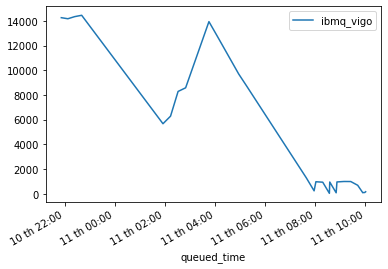

In [64]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()

xfmt = mdates.DateFormatter("%d th %H:%M")
ax.xaxis.set_major_formatter(xfmt)


for key, grp in done_rows.groupby(['backend']):
    if key == 'ibmq_vigo':
        ax = grp.plot(ax=ax, kind='line', x='queued_time', y='total_runtime', label=key)


plt.legend()


In [11]:
#Get previously run jobs (if you forgot to save them/ error caused jupyter to stop running)
#PARAMETERS
max_jobs_per_machine = 1000
machines = [e for e in list(map( lambda x: x.name(), provider.backends()))[1:]]
start_time = datetime.datetime(2020,6,10,21,0,0)

jobs = [provider.get_backend(machine).jobs(limit=max_jobs_per_machine, status='DONE', start_datetime = start_time) for machine in machines]
jobs = [y for x in jobs for y in x]
done_rows = pd.DataFrame({'job_id': [job.job_id() for job in jobs],'backend': [job.backend() for job in jobs],'finish_time': [job.time_per_step() for job in jobs],'output': [job.result().get_counts() for job in jobs]},columns=['job_id','backend','finish_time','output'])

c:\users\annanay\anaconda3\envs\project\lib\site-packages\qiskit\providers\ibmq\ibmqbackend.py:452: UserWarning: Unless a UTC timezone information is present, the parameters `start_datetime` and `end_datetime` are now expected to be in local time instead of UTC.
  return self._provider.backends.jobs(


AttributeError: 'list' object has no attribute 'job_id'

In [15]:
done_rows.to_csv('overnight_data_times_only',index=False)

In [14]:
done_rows = pd.DataFrame({'job_id': [job.job_id() for job in jobs],'backend': [job.backend() for job in jobs],'finish_time': [job.time_per_step() for job in jobs],'output': [job.result().get_counts() for job in jobs]},columns=['job_id','backend','finish_time','output'])

<ipython-input-14-11b0281f4ee2>:1: UserWarning: The time per step date and time information is returned in local time now, rather than UTC.
  done_rows = pd.DataFrame({'job_id': [job.job_id() for job in jobs],'backend': [job.backend() for job in jobs],'finish_time': [job.time_per_step() for job in jobs],'output': [job.result().get_counts() for job in jobs]},columns=['job_id','backend','finish_time','output'])
